<a href="https://colab.research.google.com/github/Gayathri14-07/carbonsense/blob/main/Credit_Card_Fraud_Detection_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting Professional Credit Card Fraud Detection Pipeline...

Total Samples: 10000
Fraud Cases: 50 (0.50%)

Training set size: 8000 | Test set size: 2000
--- Calculated Class Weights (1:Fraud): 199.00

Starting GridSearchCV for Class-Weighted Random Forest (Optimizing F1-Score)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Hyperparameters Found: {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}

            MODEL EVALUATION (OPTIMIZED RANDOM FOREST - CLASS WEIGHTING)
Classification Report:
              precision    recall  f1-score   support

  Normal (0)       0.99      1.00      1.00      1990
   Fraud (1)       0.00      0.00      0.00        10

    accuracy                           0.99      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.99      0.99      0.99      2000

AUC-ROC Score: 0.5961
False Negatives (Fraud transactions MISSED - DANGER!): 10
True Positives (Correctly identified fraud): 0

    SMOTE OVER-

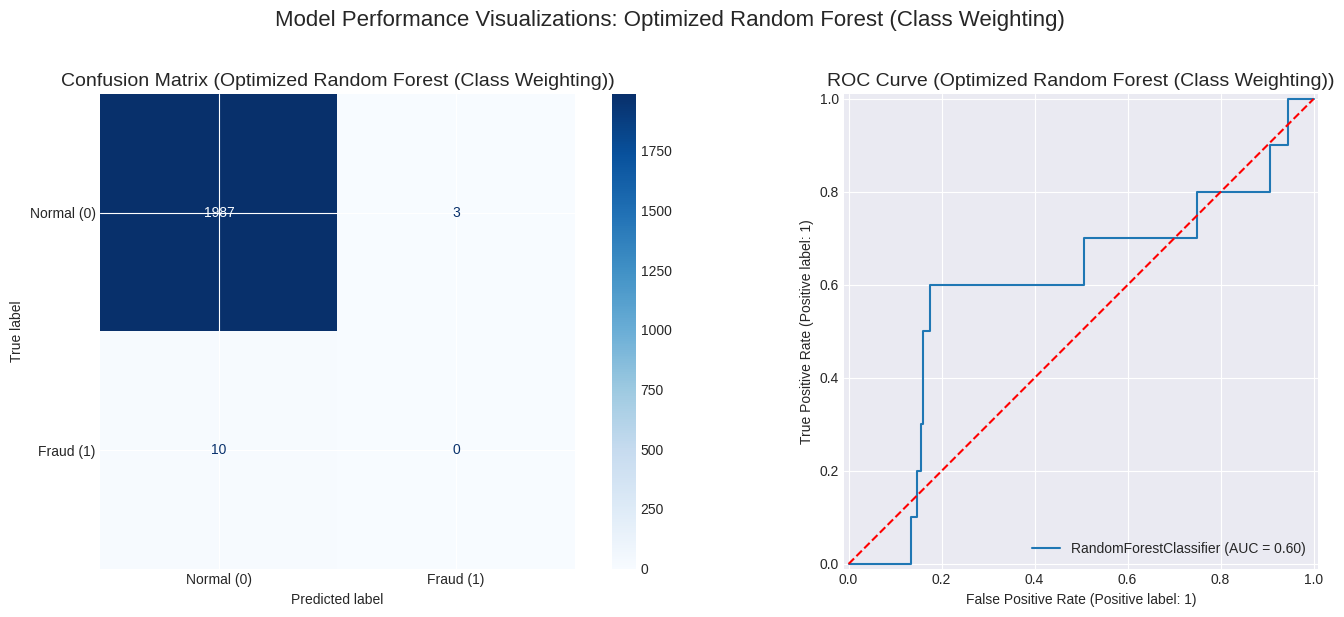

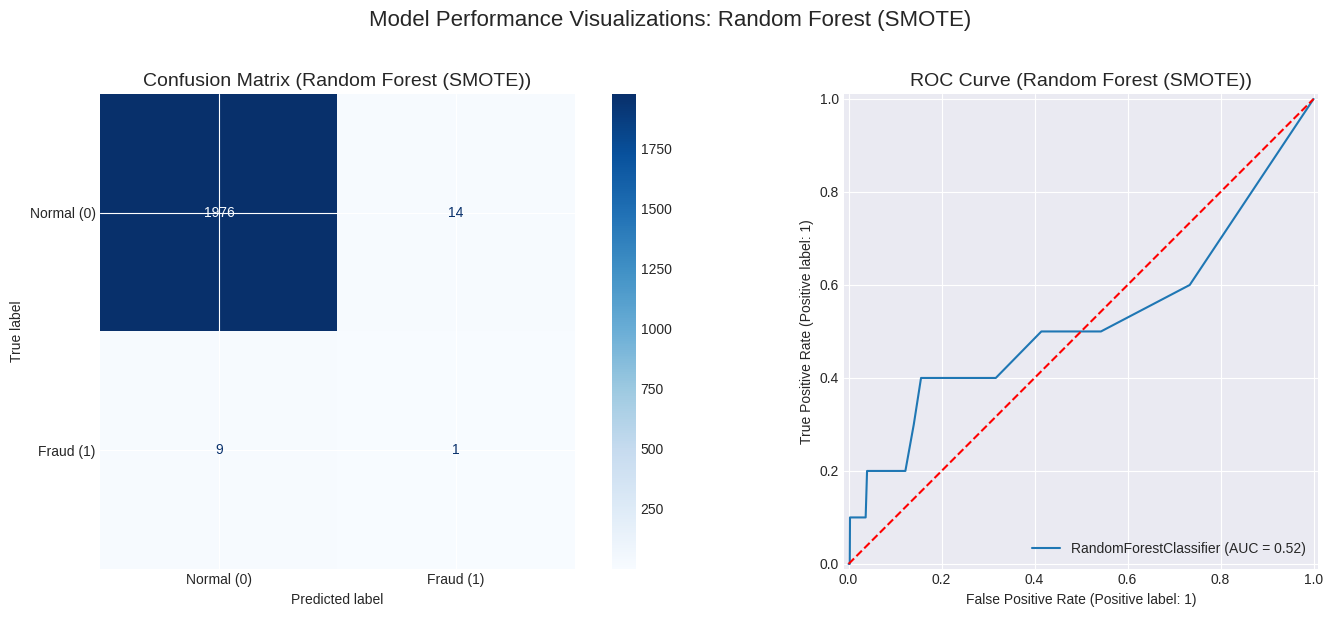

In [3]:
# Credit Card Fraud Detection Pipeline with Imbalance Handling, Hyperparameter Tuning, and Visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Added imports for advanced model and tuning
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier # Using Random Forest for higher performance
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

def calculate_class_weights(y):
    """Calculates class weights to handle imbalanced data."""
    # Count of each class
    total_samples = len(y)
    fraud_count = y.sum()
    normal_count = total_samples - fraud_count

    # Calculate scale factor for fraud cases to balance the weights
    scale_factor = normal_count / fraud_count

    # Weights for the model: {0: weight_for_normal, 1: weight_for_fraud}
    # This weights the fraud class heavily (Normal_Count / Fraud_Count)
    class_weights = {0: 1, 1: scale_factor}
    print(f"--- Calculated Class Weights (1:Fraud): {scale_factor:.2f}")
    return class_weights

def plot_metrics(model, X_test, y_test, title_suffix):
    """Generates and displays Confusion Matrix and ROC Curve for the model."""
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, model.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (0)', 'Fraud (1)'])
    disp.plot(cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix ({title_suffix})', fontsize=14)

    # 2. ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[1])
    axes[1].plot([0, 1], [0, 1], 'r--') # Plot baseline
    axes[1].set_title(f'ROC Curve ({title_suffix})', fontsize=14)

    plt.suptitle(f"Model Performance Visualizations: {title_suffix}", fontsize=16, y=1.02)
    plt.tight_layout()

def predict_new_transaction(model, scaler, new_data_dict, feature_names):
    """Predicts fraud status for a new transaction and prints the result."""
    print("\n" + "="*70)
    print("              NEW TRANSACTION PREDICTION DEMONSTRATION")
    print("="*70)

    # Convert input dict to DataFrame and ensure correct column order
    new_df = pd.DataFrame([new_data_dict], columns=feature_names)

    # Scale Time and Amount using the fitted scaler
    scaler_features = ['Time', 'Amount']
    new_df_scaled = new_df.copy()
    new_df_scaled[scaler_features] = scaler.transform(new_df[scaler_features])

    # Make prediction
    prediction = model.predict(new_df_scaled)[0]
    probability = model.predict_proba(new_df_scaled)[:, 1][0]

    status = "FRAUD" if prediction == 1 else "NORMAL"

    print(f"Input Data:\n{new_df.to_string(index=False)}")
    print("-" * 70)
    print(f"Prediction (using Optimized Random Forest):")
    print(f"-> Predicted Class: {status}")
    print(f"-> Fraud Probability Score: {probability:.4f}")
    print("="*70)
    return status, probability

def run_fraud_detection_pipeline():
    """
    Executes the full machine learning pipeline for fraud detection,
    including hyperparameter tuning and model comparison.
    """

    print("Starting Professional Credit Card Fraud Detection Pipeline...")

    # --- 1. DATA ACQUISITION (PLACEHOLDER) ---
    N_SAMPLES = 10000
    N_FRAUD = 50  # Only 0.5% fraud cases

    np.random.seed(42)
    feature_cols = [f'V{i}' for i in range(1, 11)] + ['Time', 'Amount']
    data = pd.DataFrame(np.random.rand(N_SAMPLES, 12), columns=feature_cols)

    data['Class'] = 0
    fraud_indices = np.random.choice(N_SAMPLES, N_FRAUD, replace=False)
    data.loc[fraud_indices, 'Class'] = 1

    X = data.drop('Class', axis=1)
    y = data['Class']

    print(f"\nTotal Samples: {len(data)}")
    print(f"Fraud Cases: {y.sum()} ({y.mean()*100:.2f}%)")

    # --- 2. PREPROCESSING & SCALING ---

    scaler = StandardScaler()
    X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"\nTraining set size: {len(X_train)} | Test set size: {len(X_test)}")

    # --- 3. MODEL TRAINING: RANDOM FOREST WITH HYPERPARAMETER TUNING (Class Weights) ---

    weights = calculate_class_weights(y_train)

    # Define the model and parameter grid
    rf_model_cw = RandomForestClassifier(random_state=42, class_weight=weights)

    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [5, 10],
        'min_samples_leaf': [1, 5]
    }

    # Use StratifiedKFold for robust evaluation on imbalanced data
    cv = StratifiedKFold(n_splits=5)

    print("\nStarting GridSearchCV for Class-Weighted Random Forest (Optimizing F1-Score)...")
    grid_search = GridSearchCV(
        estimator=rf_model_cw,
        param_grid=param_grid,
        scoring='f1', # Optimize for F1-Score (balance between Precision/Recall)
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    model_cw = grid_search.best_estimator_ # The optimized model

    print(f"\nBest Hyperparameters Found: {grid_search.best_params_}")

    # --- 4. MODEL EVALUATION (OPTIMIZED CLASS WEIGHTING) ---

    y_pred_cw = model_cw.predict(X_test)
    y_proba_cw = model_cw.predict_proba(X_test)[:, 1]

    print("\n" + "="*80)
    print("            MODEL EVALUATION (OPTIMIZED RANDOM FOREST - CLASS WEIGHTING)")
    print("="*80)

    print("Classification Report:")
    print(classification_report(y_test, y_pred_cw, target_names=['Normal (0)', 'Fraud (1)']))

    auc_roc_cw = roc_auc_score(y_test, y_proba_cw)
    print(f"AUC-ROC Score: {auc_roc_cw:.4f}")

    cm_cw = confusion_matrix(y_test, y_pred_cw)
    tn, fp, fn, tp = cm_cw.ravel()

    print(f"False Negatives (Fraud transactions MISSED - DANGER!): {fn}")
    print(f"True Positives (Correctly identified fraud): {tp}")

    plot_metrics(model_cw, X_test, y_test, "Optimized Random Forest (Class Weighting)")

    # --- 5. ALTERNATIVE: SMOTE (FOR RESEARCH PAPER COMPARISON) ---
    print("\n" + "="*80)
    print("    SMOTE OVER-SAMPLING (Comparison with Default Random Forest)")
    print("="*80)

    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)

    # Train a default Random Forest model on SMOTE data
    model_smote = RandomForestClassifier(random_state=42, n_estimators=100)
    print("\nTraining Default Random Forest with SMOTE data...")
    model_smote.fit(X_smote, y_smote)

    y_pred_smote = model_smote.predict(X_test)
    y_proba_smote = model_smote.predict_proba(X_test)[:, 1]

    print("\nClassification Report (SMOTE):")
    print(classification_report(y_test, y_pred_smote, target_names=['Normal (0)', 'Fraud (1)']))
    print(f"AUC-ROC Score (SMOTE): {roc_auc_score(y_test, y_proba_smote):.4f}")

    plot_metrics(model_smote, X_test, y_test, "Random Forest (SMOTE)")

    # --- 6. PREDICTING NEW DATA ---

    # Define a mock new transaction (must contain all 12 features)
    new_transaction = {
        'V1': 0.1, 'V2': 0.8, 'V3': 0.4, 'V4': 0.2, 'V5': 0.5, 'V6': 0.1,
        'V7': 0.7, 'V8': 0.3, 'V9': 0.9, 'V10': 0.1, 'Time': 170000, 'Amount': 5000.0
    }

    # Use the best model (model_cw) for the real-world prediction demo
    predict_new_transaction(model_cw, scaler, new_transaction, X.columns.tolist())

    # Display all plots
    print("\nDisplaying all model performance plots...")
    plt.show()

if __name__ == "__main__":
    run_fraud_detection_pipeline()
